In [1]:
import pandas, numpy

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
results = pandas.read_csv('dat/RESULTS.csv')
results

,set,drug,method,dataset,quality,sensitivity,sensitivity_sem,specificity,specificity_sem,PPV,PPV_sem,RR,SR,UR,RS,SS,US,Total
0,basic,INH,UKMYC,bootstrapped50,ALL,91.240875,0.480167,95.395150,0.367757,95.206597,0.370676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,basic,INH,UKMYC,bootstrapped50,HIGH,93.746796,0.336085,96.624866,0.352979,96.618858,0.342746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,basic,INH,UKMYC,entire,ALL,91.200000,0.000000,95.600000,0.000000,95.397490,0.000000,456.0,33.0,11.0,22.0,448.0,30.0,1000.0
3,basic,INH,UKMYC,entire,HIGH,93.913043,0.000000,96.412556,0.000000,96.428571,0.000000,432.0,23.0,5.0,16.0,404.0,26.0,906.0
4,basic,RIF,UKMYC,bootstrapped50,ALL,93.729501,0.406094,95.957331,0.314197,95.445435,0.375315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,nulls+minors,KAN,UKMYC,bootstrapped50,HIGH,84.298262,0.713334,98.322163,0.199675,95.369505,0.574964,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,nulls+minors,KAN,UKMYC,entire,ALL,76.470588,0.000000,98.730606,0.000000,96.086957,0.000000,221.0,56.0,12.0,9.0,650.0,50.0,1000.0
153,nulls+minors,KAN,UKMYC,entire,HIGH,84.615385,0.000000,98.543689,0.000000,96.069869,0.000000,220.0,34.0,6.0,9.0,563.0,46.0,880.0
154,nulls+minors,CAP,MGIT,bootstrapped50,ALL,74.983621,0.941786,98.295397,0.200364,94.980289,0.593964,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
who = pandas.read_csv('dat/WHO2-Annex1-table.csv')
who = who[(who.catalogue=='WHO2') & (who.FRS==0.75)]
who = who.iloc[::-1]
who

,drug,catalogue,FRS,sensitivity,specificity,PPV,sensitivity_low,sensitivity_high,specificity_low,specificity_high,PPV_low,PPV_high
43,CAP,WHO2,0.75,66.2,97.8,80.1,64.1,68.2,97.6,98.1,78.1,81.9
40,KAN,WHO2,0.75,74.9,96.7,79.3,73.4,76.3,96.4,96.9,77.9,80.7
37,ETH,WHO2,0.75,74.8,85.9,63.9,73.6,76.0,85.3,86.4,62.7,65.1
34,STM,WHO2,0.75,79.7,94.1,89.9,78.9,80.5,93.7,94.4,89.3,90.5
31,AMI,WHO2,0.75,72.8,98.3,82.8,71.0,74.6,98.1,98.5,81.2,84.4
28,DLM,WHO2,0.75,14.7,99.9,72.5,10.6,19.7,99.8,99.9,58.3,84.1
25,CFZ,WHO2,0.75,17.0,98.7,38.1,14.2,20.0,98.5,98.9,32.6,43.8
22,LEV,WHO2,0.75,84.8,96.9,88.1,83.9,85.7,96.7,97.1,87.3,89.0
19,MXF,WHO2,0.75,85.7,93.5,74.0,84.6,86.8,93.2,93.9,72.7,75.2
16,LZD,WHO2,0.75,34.0,99.8,78.4,29.2,39.0,99.7,99.9,71.3,84.5


In [4]:
df = results[(results.dataset=='bootstrapped50') & (results.quality=='ALL')]
df = df.iloc[::-1]
df

,set,drug,method,dataset,quality,sensitivity,sensitivity_sem,specificity,specificity_sem,PPV,PPV_sem,RR,SR,UR,RS,SS,US,Total
154,nulls+minors,CAP,MGIT,bootstrapped50,ALL,74.983621,0.941786,98.295397,0.200364,94.980289,0.593964,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,nulls+minors,KAN,UKMYC,bootstrapped50,ALL,76.749387,1.047989,98.699913,0.182592,96.031846,0.551728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,nulls+minors,ETH,UKMYC,bootstrapped50,ALL,72.242845,1.038901,87.015960,0.512836,69.356946,0.993347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,nulls+minors,STM,MGIT,bootstrapped50,ALL,80.735208,0.769336,95.267691,0.366638,92.251254,0.571979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,nulls+minors,AMI,UKMYC,bootstrapped50,ALL,74.267310,1.010874,99.400998,0.107511,98.067741,0.344641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,nulls+minors,DLM,UKMYC,bootstrapped50,ALL,12.298169,1.115095,99.888390,0.049223,95.484431,1.849704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,nulls+minors,CFZ,UKMYC,bootstrapped50,ALL,8.079825,0.598057,98.008384,0.210772,62.361750,3.068161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,nulls+minors,LEV,UKMYC,bootstrapped50,ALL,82.316749,0.749602,96.431502,0.287389,91.743096,0.691066,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,nulls+minors,MXF,UKMYC,bootstrapped50,ALL,85.765151,0.780545,93.824019,0.356465,84.916448,0.897091,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,nulls+minors,LZD,UKMYC,bootstrapped50,ALL,28.114421,1.933896,99.770307,0.074055,94.310212,1.857370,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_84210/3381410227.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y=numpy.arange(len(df[results.set=='basic']))
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_84210/3381410227.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  axes.set_yticks(y, df[results.set=='basic']['drug'])
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_84210/3381410227.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df[results.set=='basic'][[metric, metric+'_sem']]
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_84210/3381410227.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df[results.set=='nulls'][[metric, metric+'_sem']]
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_84210/3381410227.py:40: UserWarning: Boolean Series key will be reindexed to match

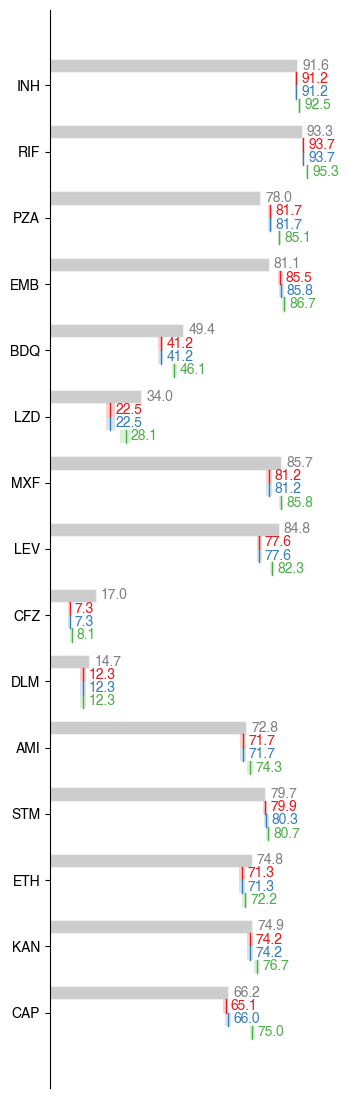

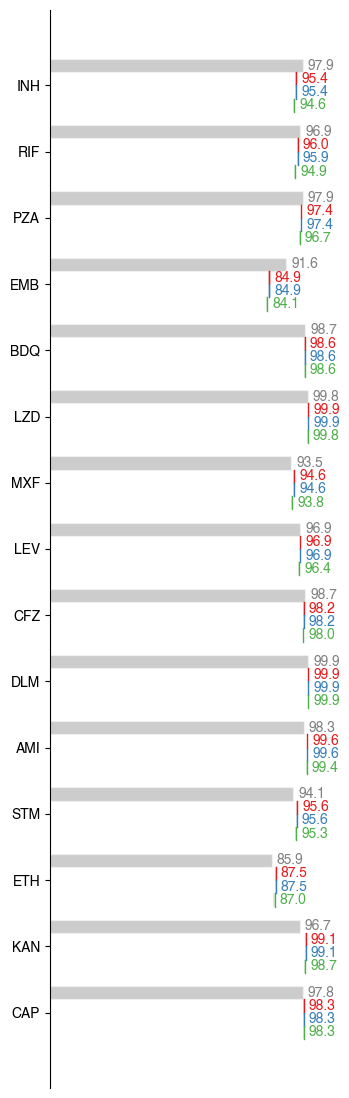

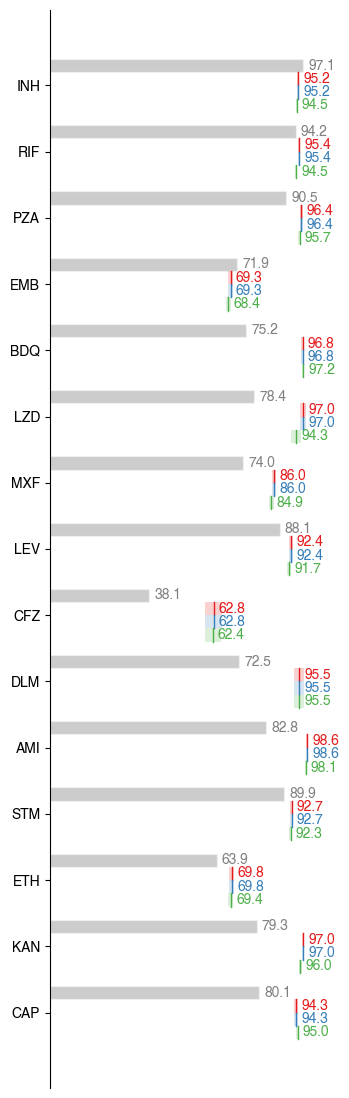

In [5]:
for metric in ['sensitivity', 'specificity','PPV']:
    fig = plt.figure(figsize=(3.5, 14))
    axes = plt.gca()
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    axes.spines["bottom"].set_visible(False)
    axes.get_xaxis().set_visible(False)
    y=numpy.arange(len(df[results.set=='basic']))
    axes.set_yticks(y, df[results.set=='basic']['drug'])
    e = (
        who[metric + "_high"] - who[metric],
        who[metric] - who[metric + "_low"],
    )
    axes.barh(y+0.3, who[metric], 0.2, label=who[metric], color='grey', edgecolor='white', linewidth=1, alpha=0.4)
    subset = who[[metric]]
    subset.columns = ['x']
    y=0
    for idx,row in subset.iterrows():
        axes.text(row.x+2, y+0.3, "%.1f" % row.x, ha="left", va='center', color='grey')
        y+=1

    subset = df[results.set=='basic'][[metric, metric+'_sem']]
    subset.columns = ['x', 'e']
    y=0
    for idx,row in subset.iterrows():
        axes.plot([row.x, row.x], [y, y+0.2], color='#e41a1c', linewidth=1)
        axes.add_patch(Rectangle((row.x-row.e, y), 2*row.e, 0.2, fc="#e41a1c", alpha=0.2))
        axes.text(row.x+2, y+0.1, "%.1f" % row.x, ha="left", va='center', color='#e41a1c')
        y+=1

    subset = df[results.set=='nulls'][[metric, metric+'_sem']]
    subset.columns = ['x', 'e']
    y=0
    for idx,row in subset.iterrows():
        axes.plot([row.x, row.x], [y-0.2, y], color='#377eb8', linewidth=1)
        axes.add_patch(Rectangle((row.x-row.e, y-0.2), 2*row.e, 0.2, fc="#377eb8", alpha=0.2))
        axes.text(row.x+2, y-0.1, "%.1f" % row.x, ha="left", va='center', color='#377eb8')
        y+=1

    subset = df[results.set=='nulls+minors'][[metric, metric+'_sem']]
    subset.columns = ['x', 'e']
    y=0
    for idx,row in subset.iterrows():
        axes.plot([row.x, row.x], [y-0.4, y-0.2], color='#4daf4a', linewidth=1)
        axes.add_patch(Rectangle((row.x-row.e, y-0.4), 2*row.e, 0.2, fc="#4daf4a", alpha=0.2))
        axes.text(row.x+2, y-0.3, "%.1f" % row.x, ha="left", va='center', color='#4daf4a')
        y+=1


    fig.savefig('pdf/fig-results-main-'+metric+'.pdf', bbox_inches='tight')